## Translating DBLP queries to OpenAlex with LLMs fewshot

In [11]:
# import libraries
import re
import json
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from openai import OpenAI
from collections import defaultdict

## Testing meta-llama-3.1-8b-instruct with 100 queries
The model includes 8billion parameters and is one of the samallest available models at Academic Cloud.

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
input_file = "../../data/DBLP_to_OpenAlex_input_fewshot.json"
output_file = "few_shot_entity_aligned_output_llama_dblp_openalex.json"

with open(input_file, "r", encoding="utf-8") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question: {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open(output_file, "w", encoding="utf-8") as file:
    json.dump(translated_dataset, file, indent=4)

print(f"Translated SPARQL queries saved to '{output_file}'.")

Translated SPARQL queries saved to 'few_shot_entity_aligned_output_llama_dblp_openalex.json'.


In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
input_file = "../../data/DBLP_to_OpenAlex_input_fewshot.json"
output_file = "few_shot_entity_aligned_output_mistral_dblp_openalex.json"

with open(input_file, "r", encoding="utf-8") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question: {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open(output_file, "w", encoding="utf-8") as file:
    json.dump(translated_dataset, file, indent=4)

print(f"Translated SPARQL queries saved to '{output_file}'.")

Translated SPARQL queries saved to 'few_shot_entity_aligned_output_mistral_dblp_openalex.json'.


## Analysis of the results
Extracting the SPARQL queries from LLM output for **mistral-large-instruct**.

In [5]:
def extract_sparql_queries(llm_output):
    """
    Extracts the final SPARQL query from the LLM output.
    Handles cases where queries are enclosed within <sparql>...</sparql> tags or ```sparql``` blocks.
    Removes inline comments marked with # before any other processing.
    """
    # First, remove inline comments marked with #
    llm_output = re.sub(r"# .*?(\n|$)", "\n", llm_output)
    
    # Regex pattern to capture content between <sparql> and </sparql>
    pattern_sparql_tags = r"<sparql>(.*?)</sparql>"
    matches_sparql_tags = re.findall(pattern_sparql_tags, llm_output, re.DOTALL)
    
    if matches_sparql_tags:
        query = " ".join(matches_sparql_tags[-1].replace("\n", " ").split())
    else:
        # Regex pattern to capture content between ```sparql``` blocks
        pattern_code_block = r"```sparql(.*?)```"
        matches_code_block = re.findall(pattern_code_block, llm_output, re.DOTALL)
        
        if matches_code_block:
            query = " ".join(matches_code_block[-1].replace("\n", " ").split())
        else:
            # Alternative extraction for inline SPARQL queries
            pattern_inline = r"(PREFIX .*?SELECT .*? WHERE \{.*?\})"
            matches_inline = re.findall(pattern_inline, llm_output, re.DOTALL)
            
            query = " ".join(matches_inline[-1].replace("\n", " ").split()) if matches_inline else ""
    
    # Remove trailing </sparql> tags if still present
    query = re.sub(r"</sparql>$", "", query).strip()
    
    return query

def process_input_file(input_file, output_file):
    """
    Reads the input JSON file, processes the data, extracts SPARQL queries,
    removes inline comments, and writes the cleaned data to an output JSON file.
    """
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    cleaned_data = []
    failed_queries = []
    total_entries = len(data)
    extracted_count = 0
    
    for entry in data:
        context = entry.get("context", {})
        natural_language_question = context.get("natural_language_question", "")
        
        # Extract and clean the final SPARQL query
        llm_output = entry.get("sparql_query_kg2", "")
        final_sparql_query = extract_sparql_queries(llm_output)
        
        if final_sparql_query:
            cleaned_entry = {
                "natural_language_question": natural_language_question,
                "sparql_query_kg2": final_sparql_query
            }
            cleaned_data.append(cleaned_entry)
            extracted_count += 1
        else:
            failed_queries.append({
                "natural_language_question": natural_language_question,
                "sparql_query_raw": llm_output
            })
    
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(cleaned_data, f, indent=2)
    
    # Print statistics
    failed_count = total_entries - extracted_count
    success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0
    
    print(f"Processed {total_entries} entries.")
    print(f"Successfully extracted queries: {extracted_count}")
    print(f"Failed queries: {failed_count}")
    print(f"Extraction success rate: {success_rate:.2f}%")

# Define file paths
input_file = "few_shot_entity_aligned_output_mistral_dblp_openalex.json"
output_file = "few_shot_entity_aligned_mistral_dblp_openalex_extracted.json"

# Process the input file and extract SPARQL queries
process_input_file(input_file, output_file)

print(f"Extracted SPARQL queries saved to {output_file}")


Processed 100 entries.
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%
Extracted SPARQL queries saved to few_shot_entity_aligned_mistral_dblp_openalex_extracted.json


Extracting the SPARQL queries from LLM output for **meta-llama-3.1-8b-instruct**.

In [8]:
def extract_sparql_queries(llm_output):
    """
    Extracts the final SPARQL query from the LLM output.
    Handles cases where queries are enclosed within <sparql>...</sparql> tags or ```sparql``` blocks.
    Removes inline comments marked with # before any other processing.
    """
    # First, remove inline comments marked with #
    llm_output = re.sub(r"# .*?(\n|$)", "\n", llm_output)
    
    # Regex pattern to capture content between <sparql> and </sparql>
    pattern_sparql_tags = r"<sparql>(.*?)</sparql>"
    matches_sparql_tags = re.findall(pattern_sparql_tags, llm_output, re.DOTALL)
    
    if matches_sparql_tags:
        query = " ".join(matches_sparql_tags[-1].replace("\n", " ").split())
    else:
        # Regex pattern to capture content between ```sparql``` blocks
        pattern_code_block = r"```sparql(.*?)```"
        matches_code_block = re.findall(pattern_code_block, llm_output, re.DOTALL)
        
        if matches_code_block:
            query = " ".join(matches_code_block[-1].replace("\n", " ").split())
        else:
            # Alternative extraction for inline SPARQL queries
            pattern_inline = r"(PREFIX .*?SELECT .*? WHERE \{.*?\})"
            matches_inline = re.findall(pattern_inline, llm_output, re.DOTALL)
            
            query = " ".join(matches_inline[-1].replace("\n", " ").split()) if matches_inline else ""
    
    # Remove trailing </sparql> tags if still present
    query = re.sub(r"</sparql>$", "", query).strip()
    
    return query

def process_input_file(input_file, output_file):
    """
    Reads the input JSON file, processes the data, extracts SPARQL queries,
    removes inline comments, and writes the cleaned data to an output JSON file.
    """
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    cleaned_data = []
    failed_queries = []
    total_entries = len(data)
    extracted_count = 0
    
    for entry in data:
        context = entry.get("context", {})
        natural_language_question = context.get("natural_language_question", "")
        
        # Extract and clean the final SPARQL query
        llm_output = entry.get("sparql_query_kg2", "")
        final_sparql_query = extract_sparql_queries(llm_output)
        
        if final_sparql_query:
            cleaned_entry = {
                "natural_language_question": natural_language_question,
                "sparql_query_kg2": final_sparql_query
            }
            cleaned_data.append(cleaned_entry)
            extracted_count += 1
        else:
            failed_queries.append({
                "natural_language_question": natural_language_question,
                "sparql_query_raw": llm_output
            })
    
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(cleaned_data, f, indent=2)
    
    # Print statistics
    failed_count = total_entries - extracted_count
    success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0
    
    print(f"Processed {total_entries} entries.")
    print(f"Successfully extracted queries: {extracted_count}")
    print(f"Failed queries: {failed_count}")
    print(f"Extraction success rate: {success_rate:.2f}%")

# Define file paths
input_file = "few_shot_entity_aligned_output_llama_dblp_openalex.json"
output_file = "few_shot_entity_aligned_llama_dblp_openalex_extracted.json"

# Process the input file and extract SPARQL queries
process_input_file(input_file, output_file)

print(f"Extracted SPARQL queries saved to {output_file}")

Processed 100 entries.
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%
Extracted SPARQL queries saved to few_shot_entity_aligned_llama_dblp_openalex_extracted.json


In [14]:
# File paths
input_file = "few_shot_entity_aligned_llama_dblp_openalex_extracted.json"
output_file = "few_shot_entity_aligned_llama_dblp_openalex_executed.json"
OpenAlex_endpoint = "https://semopenalex.org/sparql"

# Load translated queries
with open(input_file, "r", encoding="utf-8") as f:
    translated_queries = json.load(f)

# Initialize counters
success_count = 0
fail_count = 0
query_results = []
failed_queries = []

# Function to execute SPARQL query
def run_sparql_query(query):
    headers = {"Accept": "application/json"}
    params = {"query": query, "format": "json"}
    response = requests.get(OpenAlex_endpoint, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json(), True
    else:
        return response.text, False

# Execute each query
for query_data in translated_queries:
    query = query_data.get("sparql_OpenAlex", "")
    if not query:
        continue
    
    result, success = run_sparql_query(query)
    if success:
        success_count += 1
    else:
        fail_count += 1
        failed_queries.append({
            "id": query_data["id"],
            "template_id": query_data["template_id"],
            "sparql_query": query,
            "error": result
        })
    
    query_results.append({
        "id": query_data["id"],
        "template_id": query_data["template_id"],
        "sparql_query": query,
        "success": success,
        "result": result
    })

# Save results to JSON
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(query_results, f, indent=4, ensure_ascii=False)

# Print statistics
print(f"Total queries executed: {len(translated_queries)}")
print(f"Successful queries: {success_count}")
print(f"Failed queries: {fail_count}")

# Print failed queries explicitly
if failed_queries:
    print("\nFailed Queries:")
    for failed in failed_queries:
        print(f"ID: {failed['id']}, Template: {failed['template_id']}")
        print(f"Query: {failed['sparql_query']}")
        print(f"Error: {failed['error']}\n")

Total queries executed: 100
Successful queries: 0
Failed queries: 0


## Get the results and compare to gold label answers

Results for **llama-3.1-8b-instruct**	

Total Queries: 100
Successful Queries: 0
Failed Queries: 0
Accuracy: 0.00%


C:\Users\malte\AppData\Local\Temp\ipykernel_10476\2264470491.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


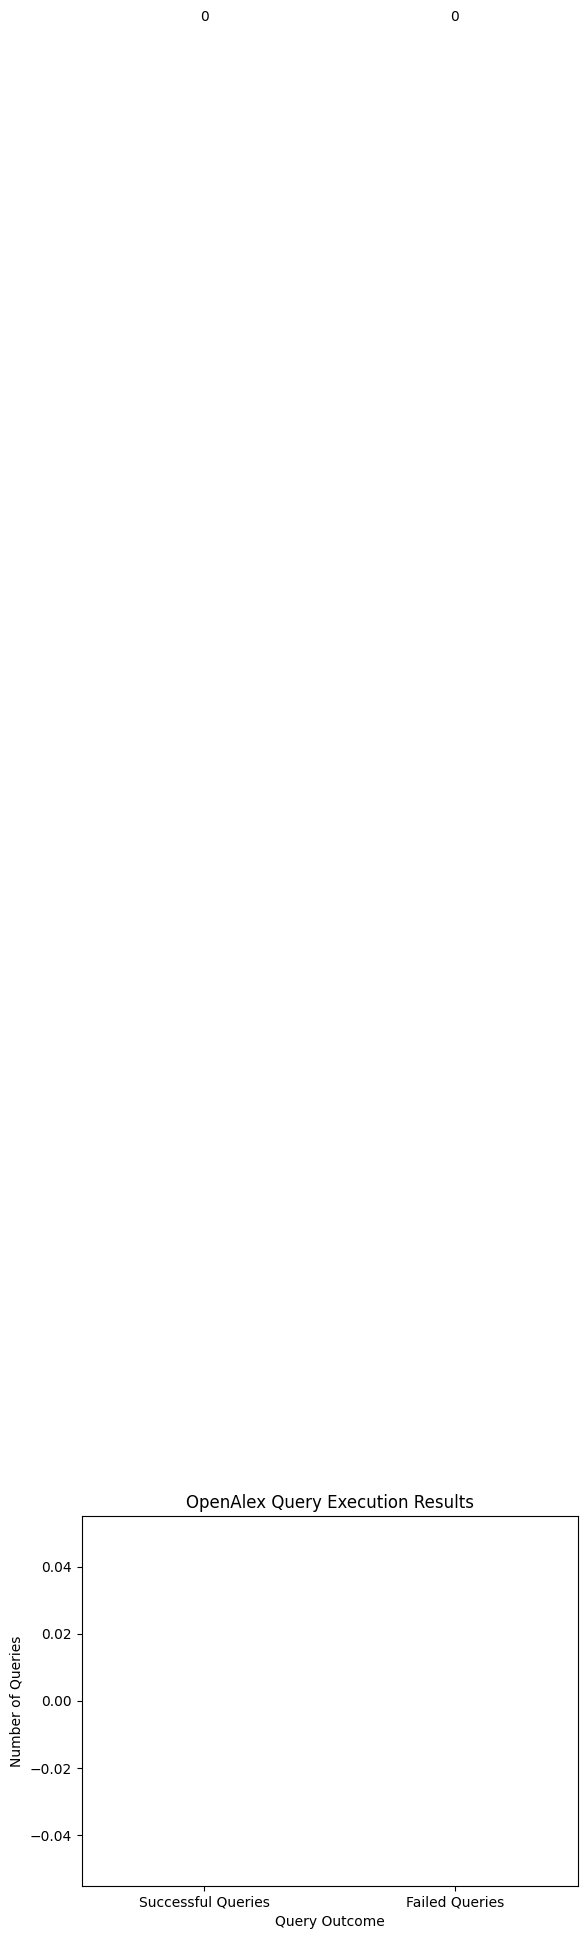

In [13]:
# File paths
input_file = "few_shot_entity_aligned_llama_dblp_openalex_extracted.json"
output_file = "few_shot_entity_aligned_llama_dblp_openalex_executed.json"
OpenAlex_endpoint = "https://semopenalex.org/sparql"

# Load translated queries
with open(input_file, "r", encoding="utf-8") as f:
    translated_queries = json.load(f)

# Initialize counters
success_count = 0
fail_count = 0
query_results = []
failed_queries = []

# Function to execute SPARQL query
def run_sparql_query(query):
    headers = {"Accept": "application/json"}
    params = {"query": query, "format": "json"}
    response = requests.get(OpenAlex_endpoint, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json(), True
    else:
        return response.text, False

# Execute each query
for query_data in translated_queries:
    query = query_data.get("sparql_OpenAlex", "")
    if not query:
        continue
    
    result, success = run_sparql_query(query)
    if success:
        success_count += 1
    else:
        fail_count += 1
        failed_queries.append({
            "id": query_data["id"],
            "template_id": query_data["template_id"],
            "sparql_query": query,
            "error": result
        })
    
    query_results.append({
        "id": query_data["id"],
        "template_id": query_data["template_id"],
        "sparql_query": query,
        "success": success,
        "result": result
    })

# Save results to JSON
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(query_results, f, indent=4, ensure_ascii=False)

# Print statistics
total_queries = len(translated_queries)
accuracy = (success_count / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {success_count}")
print(f"Failed Queries: {fail_count}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualization: Query Execution Results
categories = ['Successful Queries', 'Failed Queries']
counts = [success_count, fail_count]
colors = ['green', 'red']

plt.bar(categories, counts, color=colors)
plt.title('OpenAlex Query Execution Results')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Total Queries: 100
Successful Queries: 84
Failed Queries: 16
Accuracy: 84.00%


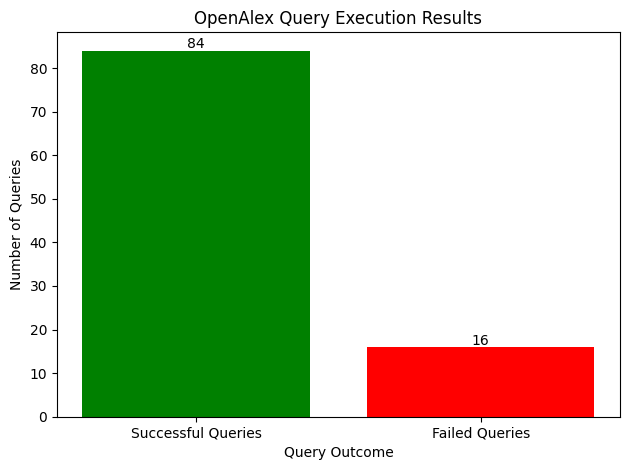

In [15]:
# File paths
input_file = "few_shot_entity_aligned_llama_dblp_openalex_extracted.json"
output_file = "few_shot_entity_aligned_llama_dblp_openalex_executed.json"
OpenAlex_endpoint = "https://semopenalex.org/sparql"

# Load extracted queries
with open(input_file, "r", encoding="utf-8") as f:
    extracted_queries = json.load(f)

# Initialize counters
success_count = 0
fail_count = 0
query_results = []
failed_queries = []

# Function to execute SPARQL query
def run_sparql_query(query):
    headers = {"Accept": "application/json"}
    params = {"query": query, "format": "json"}
    response = requests.get(OpenAlex_endpoint, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json(), True
    else:
        return response.text, False

# Execute each query
for query_data in extracted_queries:
    query = query_data.get("sparql_query_kg2", "")
    if not query:
        continue
    
    result, success = run_sparql_query(query)
    if success:
        success_count += 1
    else:
        fail_count += 1
        failed_queries.append({
            "natural_language_question": query_data["natural_language_question"],
            "sparql_query": query,
            "error": result
        })
    
    query_results.append({
        "natural_language_question": query_data["natural_language_question"],
        "sparql_query": query,
        "success": success,
        "result": result
    })

# Save results to JSON
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(query_results, f, indent=4, ensure_ascii=False)

# Print statistics
total_queries = len(extracted_queries)
accuracy = (success_count / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {success_count}")
print(f"Failed Queries: {fail_count}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualization: Query Execution Results
categories = ['Successful Queries', 'Failed Queries']
counts = [success_count, fail_count]
colors = ['green', 'red']

plt.bar(categories, counts, color=colors)
plt.title('OpenAlex Query Execution Results')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Results for **mistral-large-instruct** 

Total Queries: 100
Successful Queries: 97
Failed Queries: 3
Accuracy: 97.00%


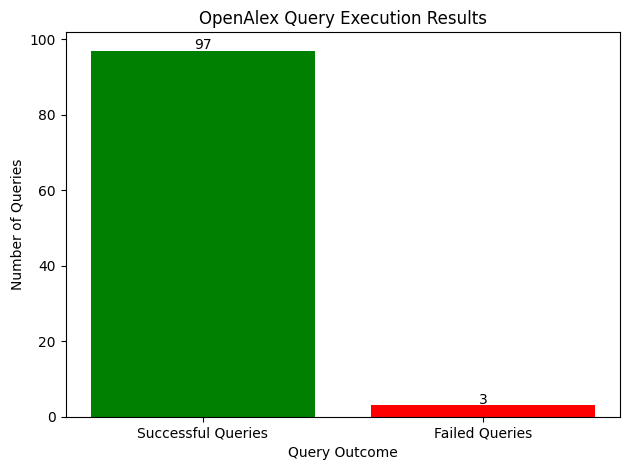

In [16]:
# File paths
input_file = "few_shot_entity_aligned_mistral_dblp_openalex_extracted.json"
output_file = "few_shot_entity_aligned_mistral_dblp_openalex_executed.json"
OpenAlex_endpoint = "https://semopenalex.org/sparql"

# Load extracted queries
with open(input_file, "r", encoding="utf-8") as f:
    extracted_queries = json.load(f)

# Initialize counters
success_count = 0
fail_count = 0
query_results = []
failed_queries = []

# Function to execute SPARQL query
def run_sparql_query(query):
    headers = {"Accept": "application/json"}
    params = {"query": query, "format": "json"}
    response = requests.get(OpenAlex_endpoint, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json(), True
    else:
        return response.text, False

# Execute each query
for query_data in extracted_queries:
    query = query_data.get("sparql_query_kg2", "")
    if not query:
        continue
    
    result, success = run_sparql_query(query)
    if success:
        success_count += 1
    else:
        fail_count += 1
        failed_queries.append({
            "natural_language_question": query_data["natural_language_question"],
            "sparql_query": query,
            "error": result
        })
    
    query_results.append({
        "natural_language_question": query_data["natural_language_question"],
        "sparql_query": query,
        "success": success,
        "result": result
    })

# Save results to JSON
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(query_results, f, indent=4, ensure_ascii=False)

# Print statistics
total_queries = len(extracted_queries)
accuracy = (success_count / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {success_count}")
print(f"Failed Queries: {fail_count}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualization: Query Execution Results
categories = ['Successful Queries', 'Failed Queries']
counts = [success_count, fail_count]
colors = ['green', 'red']

plt.bar(categories, counts, color=colors)
plt.title('OpenAlex Query Execution Results')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

## Comparison of OpenAlex output with gold label output
In the following the final output of querying OpenAlex is compared to the gold label output. **Mistral**

Need to get a better way for result comparison.

{'Total Queries': 100, 'Correct Queries': 28, 'Incorrect Queries': 0, 'Query Failed to execute': 3, 'No Answer Queries': 69, 'Accuracy (%)': 28.0, 'Execution Success Rate (ESR) (%)': 28.0}


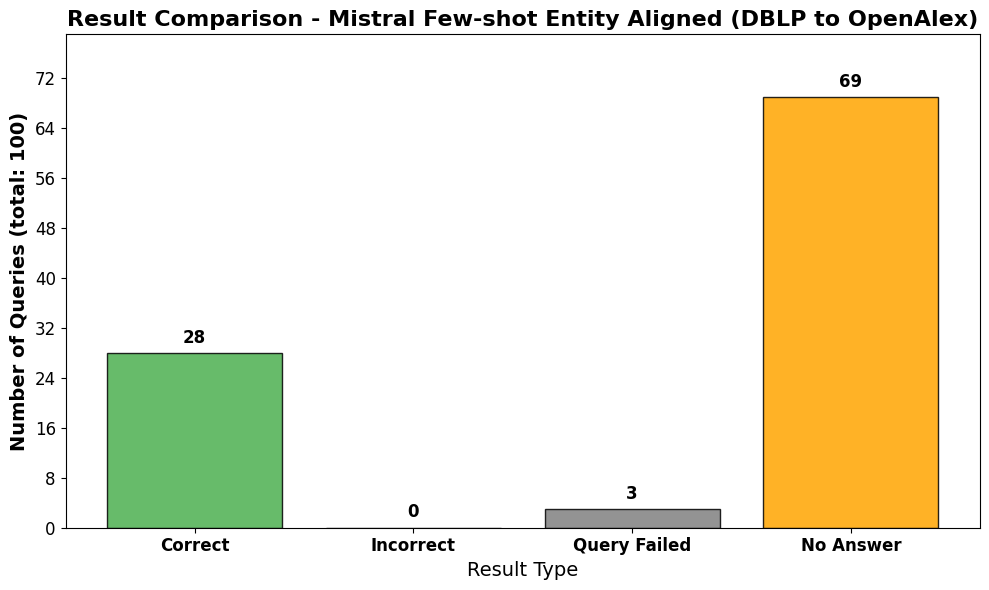

In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define file paths
solution_file_path = "../../data/OpenAlex_100_results.json"
mistral_output_file_path = "few_shot_entity_aligned_mistral_dblp_openalex_executed.json"
output_excel_file = "few_shot_mistral_dblp_openalex_results_comparison_fixed.xlsx"

# Load datasets
with open(solution_file_path, 'r', encoding='utf-8') as f:
    solution_data = json.load(f)

with open(mistral_output_file_path, 'r', encoding='utf-8') as f:
    mistral_output_data = json.load(f)

# Function to safely extract work values from bindings
def extract_work_values(bindings):
    """Extracts 'work' values safely from bindings."""
    return {binding["work"]["value"] for binding in bindings if "work" in binding}

# Create a mapping of question -> expected work values
solution_mapping = {}
for entry in solution_data:
    question = entry.get("question", "").strip()
    bindings = entry.get("result", {}).get("results", {}).get("bindings", [])
    expected_answers = extract_work_values(bindings)
    solution_mapping[question] = expected_answers  # Store as a set for comparison

# Ensure 'result' is always treated as a dictionary
def get_result_dict(entry):
    """Ensures 'result' is a dictionary; if it's a string, attempt to parse it."""
    result = entry.get("result", {})
    if isinstance(result, str):
        try:
            result = json.loads(result)  # Convert string to dictionary if needed
        except json.JSONDecodeError:
            result = {}  # Default to an empty dictionary if parsing fails
    return result

# Calculate total number of questions
total_questions = len(mistral_output_data)

# Initialize counts and results list
comparison_results = []
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0

# Compare answers
for mistral_entry in mistral_output_data:
    question = mistral_entry.get("natural_language_question", "").strip()
    result_dict = get_result_dict(mistral_entry)
    bindings = result_dict.get("results", {}).get("bindings", [])
    mistral_answers = extract_work_values(bindings)

    # Find corresponding expected answers
    expected_answers = solution_mapping.get(question, set())

    # Count query failures and no answers
    if not mistral_entry.get("success", False):
        query_failed_count += 1
        continue
    if not mistral_answers:
        no_answer_count += 1
        continue

    # Check correctness of answers
    is_correct = expected_answers == mistral_answers

    comparison_results.append({
        "question": question,
        "expected_answers": list(expected_answers),
        "mistral_answers": list(mistral_answers),
        "is_correct": is_correct
    })

    if is_correct:
        correct_count += 1
    else:
        incorrect_count += 1

    successful_executions += 1

# Save the results to an Excel file
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy and execution success rate
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

# Print summary statistics
summary_stats = {
    "Total Queries": total_questions,
    "Correct Queries": correct_count,
    "Incorrect Queries": incorrect_count,
    "Query Failed to execute": query_failed_count,
    "No Answer Queries": no_answer_count,
    "Accuracy (%)": round(accuracy, 2),
    "Execution Success Rate (ESR) (%)": round(execution_success_rate, 2)
}

print(summary_stats)

# Visualization of comparison results
categories = ['Correct', 'Incorrect', 'Query Failed', 'No Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=['#4CAF50', '#FF5733', '#808080', '#FFA500'], alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result Comparison - Mistral Few-shot Entity Aligned (DBLP to OpenAlex)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

# Enhance visual appeal
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 10)

# Show the plot
plt.tight_layout()
plt.show()


{'Total Queries': 100, 'Correct Queries': 81, 'Incorrect Queries': 12, 'Query Failed to execute': 3, 'No Answer Queries': 4, 'Accuracy (%)': 81.0, 'Execution Success Rate (ESR) (%)': 93.0}


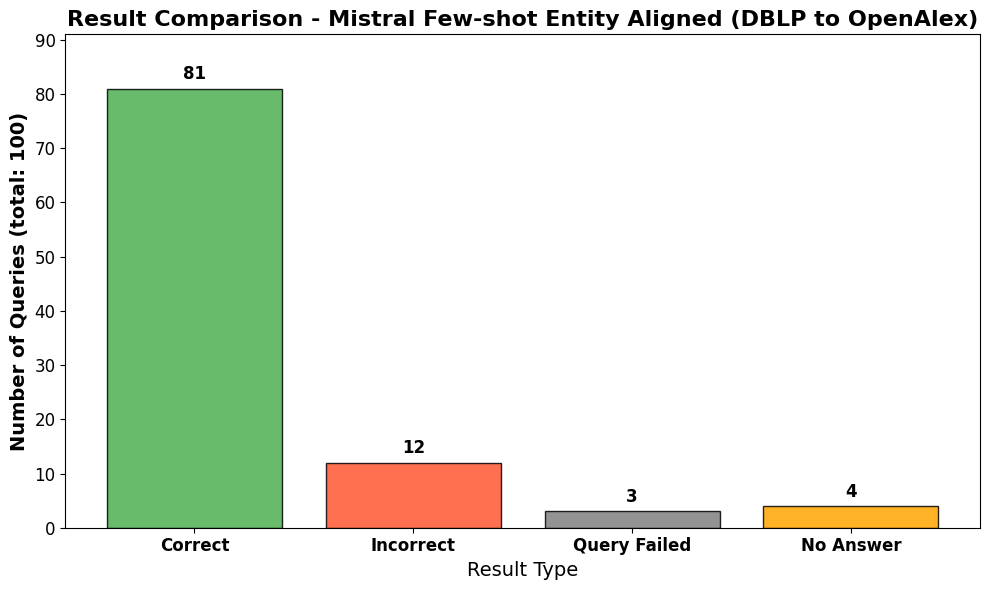

In [ ]:
import json
import pandas as pd

# Define file paths
solution_file_path = "../../data/OpenAlex_100_results.json"
mistral_output_file_path = "few_shot_entity_aligned_mistral_dblp_openalex_executed.json"
output_excel_file = "few_shot_mistral_dblp_openalex_results_comparison_fixed.xlsx"

# Load datasets
with open(solution_file_path, 'r', encoding='utf-8') as f:
    solution_data = json.load(f)

with open(mistral_output_file_path, 'r', encoding='utf-8') as f:
    mistral_output_data = json.load(f)

# Function to safely extract values from bindings
def extract_values_from_bindings(bindings):
    """Extracts all relevant values from bindings, covering various answer types."""
    extracted_values = set()
    for binding in bindings:
        if isinstance(binding, dict):
            for key, value in binding.items():
                if isinstance(value, dict) and "value" in value:
                    extracted_values.add(value["value"])
    return extracted_values

# Function to process boolean results
def extract_boolean_result(result_dict):
    """Extracts boolean results if present."""
    return {str(result_dict.get("boolean", "False")).lower()} if "boolean" in result_dict else set()

# Function to process numerical results (counts, answers, etc.)
def extract_numerical_result(bindings):
    """Extracts numerical results like count or answer values."""
    numerical_values = set()
    for binding in bindings:
        for key, value in binding.items():
            if isinstance(value, dict) and "value" in value:
                numerical_values.add(str(value["value"]))  # Convert to string for uniform comparison
    return numerical_values

# Create a mapping of question -> expected values
solution_mapping = {}
for entry in solution_data:
    question = entry.get("question", "").strip()
    result_dict = entry.get("result", {})
    bindings = result_dict.get("results", {}).get("bindings", [])

    # Extract expected answers dynamically
    expected_values = extract_values_from_bindings(bindings)
    expected_values.update(extract_boolean_result(result_dict))
    expected_values.update(extract_numerical_result(bindings))

    solution_mapping[question] = expected_values  # Store as a set for comparison

# Ensure 'result' is always treated as a dictionary
def get_result_dict(entry):
    """Ensures 'result' is a dictionary; if it's a string, attempt to parse it."""
    result = entry.get("result", {})
    if isinstance(result, str):
        try:
            result = json.loads(result)  # Convert string to dictionary if needed
        except json.JSONDecodeError:
            result = {}  # Default to an empty dictionary if parsing fails
    return result

# Calculate total number of questions
total_questions = len(mistral_output_data)

# Initialize counts and results list
comparison_results = []
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0

# Compare answers
for mistral_entry in mistral_output_data:
    question = mistral_entry.get("natural_language_question", "").strip()
    result_dict = get_result_dict(mistral_entry)
    bindings = result_dict.get("results", {}).get("bindings", [])

    # Extract answers dynamically
    mistral_answers = extract_values_from_bindings(bindings)
    mistral_answers.update(extract_boolean_result(result_dict))
    mistral_answers.update(extract_numerical_result(bindings))

    # Find corresponding expected answers
    expected_answers = solution_mapping.get(question, set())

    # Count query failures and no answers
    if not mistral_entry.get("success", False):
        query_failed_count += 1
        continue
    if not mistral_answers:
        no_answer_count += 1
        continue

    # Check correctness of answers
    is_correct = expected_answers == mistral_answers

    comparison_results.append({
        "question": question,
        "expected_answers": list(expected_answers),
        "mistral_answers": list(mistral_answers),
        "is_correct": is_correct
    })

    if is_correct:
        correct_count += 1
    else:
        incorrect_count += 1

    successful_executions += 1

# Save the results to an Excel file
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy and execution success rate
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

# Print summary statistics
summary_stats = {
    "Total Queries": total_questions,
    "Correct Queries": correct_count,
    "Incorrect Queries": incorrect_count,
    "Query Failed to execute": query_failed_count,
    "No Answer Queries": no_answer_count,
    "Accuracy (%)": round(accuracy, 2),
    "Execution Success Rate (ESR) (%)": round(execution_success_rate, 2)
}

print(summary_stats)

# Visualization of comparison results
import matplotlib.pyplot as plt

# Visualization of comparison results
categories = ['Correct', 'Incorrect', 'Query Failed', 'No Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=['#4CAF50', '#FF5733', '#808080', '#FFA500'], alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result Comparison - Mistral Few-shot Entity Aligned (DBLP to OpenAlex)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

# Enhance visual appeal
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 10)

# Show the plot
plt.tight_layout()
plt.show()



Questions with No Answer:
Question: Which publications did Ranst, Wiebe Van author?
Expected Answers: []

Question: Which papers did St\u00E9phane R. publish in the last four years?
Expected Answers: []

Question: What are the titles of the papers that Sheu, T. W. H. published in the last two years and in which venues?
Expected Answers: []

Question: What are the papers that Andr\u00E9 Kaup and C. Lin published?
Expected Answers: ['https://semopenalex.org/work/W4403854150', 'https://semopenalex.org/work/W4390873083', 'https://semopenalex.org/work/W3114401400', 'https://semopenalex.org/work/W2999868813', 'https://semopenalex.org/work/W4392909599', 'https://semopenalex.org/work/W2160186363', 'https://semopenalex.org/work/W1987621308', 'https://semopenalex.org/work/W2006784329', 'https://semopenalex.org/work/W4394699117', 'https://semopenalex.org/work/W2034318424', 'https://semopenalex.org/work/W2139969338', 'https://semopenalex.org/work/W2889250665', 'https://semopenalex.org/work/W20303

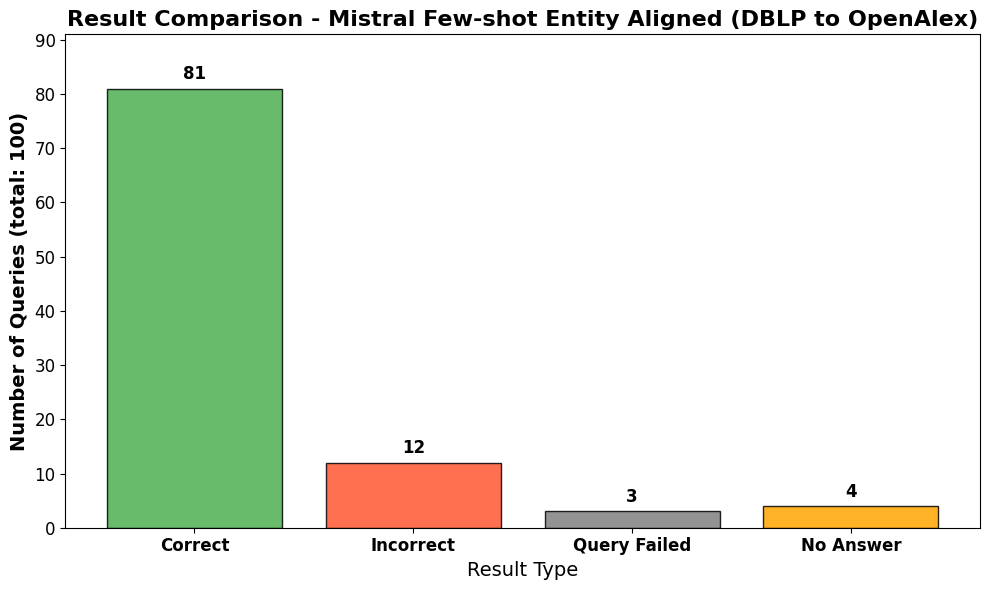

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define file paths
solution_file_path = "../../data/OpenAlex_100_results.json"
mistral_output_file_path = "few_shot_entity_aligned_mistral_dblp_openalex_executed.json"
output_excel_file = "few_shot_mistral_dblp_openalex_results_comparison_fixed.xlsx"

# Load datasets
with open(solution_file_path, 'r', encoding='utf-8') as f:
    solution_data = json.load(f)

with open(mistral_output_file_path, 'r', encoding='utf-8') as f:
    mistral_output_data = json.load(f)

# Function to safely extract values from bindings
def extract_values_from_bindings(bindings):
    """Extracts all relevant values from bindings, covering various answer types."""
    extracted_values = set()
    for binding in bindings:
        if isinstance(binding, dict):
            for key, value in binding.items():
                if isinstance(value, dict) and "value" in value:
                    extracted_values.add(value["value"])
    return extracted_values

# Function to process boolean results
def extract_boolean_result(result_dict):
    """Extracts boolean results if present."""
    return {str(result_dict.get("boolean", "False")).lower()} if "boolean" in result_dict else set()

# Function to process numerical results (counts, answers, etc.)
def extract_numerical_result(bindings):
    """Extracts numerical results like count or answer values."""
    numerical_values = set()
    for binding in bindings:
        for key, value in binding.items():
            if isinstance(value, dict) and "value" in value:
                numerical_values.add(str(value["value"]))  # Convert to string for uniform comparison
    return numerical_values

# Create a mapping of question -> expected values
solution_mapping = {}
for entry in solution_data:
    question = entry.get("question", "").strip()
    result_dict = entry.get("result", {})
    bindings = result_dict.get("results", {}).get("bindings", [])

    # Extract expected answers dynamically
    expected_values = extract_values_from_bindings(bindings)
    expected_values.update(extract_boolean_result(result_dict))
    expected_values.update(extract_numerical_result(bindings))

    solution_mapping[question] = expected_values  # Store as a set for comparison

# Ensure 'result' is always treated as a dictionary
def get_result_dict(entry):
    """Ensures 'result' is a dictionary; if it's a string, attempt to parse it."""
    result = entry.get("result", {})
    if isinstance(result, str):
        try:
            result = json.loads(result)  # Convert string to dictionary if needed
        except json.JSONDecodeError:
            result = {}  # Default to an empty dictionary if parsing fails
    return result

# Calculate total number of questions
total_questions = len(mistral_output_data)

# Initialize counts and results list
comparison_results = []
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0
no_answer_entries = []  # Store no-answer entries for printing

# Compare answers
for mistral_entry in mistral_output_data:
    question = mistral_entry.get("natural_language_question", "").strip()
    result_dict = get_result_dict(mistral_entry)
    bindings = result_dict.get("results", {}).get("bindings", [])

    # Extract answers dynamically
    mistral_answers = extract_values_from_bindings(bindings)
    mistral_answers.update(extract_boolean_result(result_dict))
    mistral_answers.update(extract_numerical_result(bindings))

    # Find corresponding expected answers
    expected_answers = solution_mapping.get(question, set())

    # Count query failures and no answers
    if not mistral_entry.get("success", False):
        query_failed_count += 1
        continue
    if not mistral_answers:
        no_answer_count += 1
        no_answer_entries.append({
            "question": question,
            "expected_answers": list(expected_answers)
        })
        continue

    # Check correctness of answers
    is_correct = expected_answers == mistral_answers

    comparison_results.append({
        "question": question,
        "expected_answers": list(expected_answers),
        "mistral_answers": list(mistral_answers),
        "is_correct": is_correct
    })

    if is_correct:
        correct_count += 1
    else:
        incorrect_count += 1

    successful_executions += 1

# Save the results to an Excel file
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Print no-answer questions
if no_answer_entries:
    print("\nQuestions with No Answer:")
    for entry in no_answer_entries:
        print(f"Question: {entry['question']}")
        print(f"Expected Answers: {entry['expected_answers']}\n")

# Calculate accuracy and execution success rate
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

# Print summary statistics
summary_stats = {
    "Total Queries": total_questions,
    "Correct Queries": correct_count,
    "Incorrect Queries": incorrect_count,
    "Query Failed to execute": query_failed_count,
    "No Answer Queries": no_answer_count,
    "Accuracy (%)": round(accuracy, 2),
    "Execution Success Rate (ESR) (%)": round(execution_success_rate, 2)
}

print(summary_stats)

# Visualization of comparison results
categories = ['Correct', 'Incorrect', 'Query Failed', 'No Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=['#4CAF50', '#FF5733', '#808080', '#FFA500'], alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result Comparison - Mistral Few-shot Entity Aligned (DBLP to OpenAlex)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

# Enhance visual appeal
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 10)

# Show the plot
plt.tight_layout()
plt.show()

- For the Query Failed, change the ORCID in the input dataset because its not working with the current ORCID.
- For the incorrect queries for calculating the average there are several questions where the LLM is not able to generate the correct query.
- Run the LLMs again with correct ORCID and hope for even better results.
- Maybe extraction process needs to be adjusted then


Questions with No Answer:
Question: Which publications did Ranst, Wiebe Van author?
Expected Answers: []

Question: Which papers did St\u00E9phane R. publish in the last four years?
Expected Answers: []

Question: What are the titles of the papers that Sheu, T. W. H. published in the last two years and in which venues?
Expected Answers: []

Question: What are the papers that Andr\u00E9 Kaup and C. Lin published?
Expected Answers: ['https://semopenalex.org/work/W4403854150', 'https://semopenalex.org/work/W4390873083', 'https://semopenalex.org/work/W3114401400', 'https://semopenalex.org/work/W2999868813', 'https://semopenalex.org/work/W4392909599', 'https://semopenalex.org/work/W2160186363', 'https://semopenalex.org/work/W1987621308', 'https://semopenalex.org/work/W2006784329', 'https://semopenalex.org/work/W4394699117', 'https://semopenalex.org/work/W2034318424', 'https://semopenalex.org/work/W2139969338', 'https://semopenalex.org/work/W2889250665', 'https://semopenalex.org/work/W20303

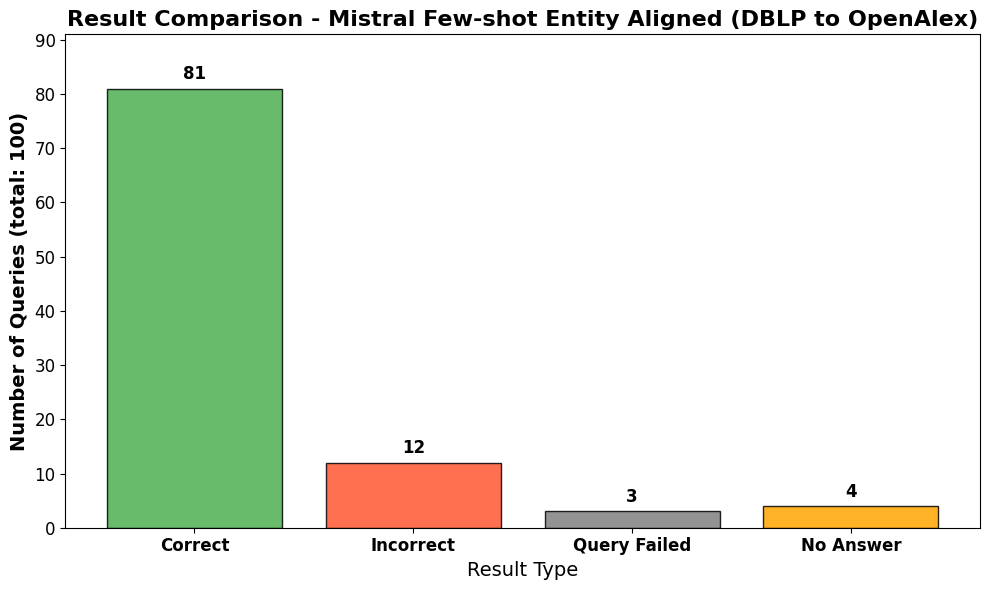

In [36]:
# Define file paths
solution_file_path = "../../data/OpenAlex_100_results.json"
mistral_output_file_path = "few_shot_entity_aligned_mistral_dblp_openalex_executed.json"
output_excel_file = "few_shot_mistral_dblp_openalex_results_comparison_fixed.xlsx"

# Load datasets
with open(solution_file_path, 'r', encoding='utf-8') as f:
    solution_data = json.load(f)

with open(mistral_output_file_path, 'r', encoding='utf-8') as f:
    mistral_output_data = json.load(f)

# Function to safely extract values from bindings
def extract_values_from_bindings(bindings):
    """Extracts all relevant values from bindings, covering various answer types."""
    extracted_values = set()
    for binding in bindings:
        if isinstance(binding, dict):
            for key, value in binding.items():
                if isinstance(value, dict) and "value" in value:
                    extracted_values.add(value["value"])
    return extracted_values

# Function to process boolean results
def extract_boolean_result(result_dict):
    """Extracts boolean results if present."""
    return {str(result_dict.get("boolean", "False")).lower()} if "boolean" in result_dict else set()

# Function to process numerical results (counts, answers, etc.)
def extract_numerical_result(bindings):
    """Extracts numerical results like count or answer values."""
    numerical_values = set()
    for binding in bindings:
        for key, value in binding.items():
            if isinstance(value, dict) and "value" in value:
                numerical_values.add(str(value["value"]))  # Convert to string for uniform comparison
    return numerical_values

# Create a mapping of question -> expected values
solution_mapping = {}
for entry in solution_data:
    question = entry.get("question", "").strip()
    result_dict = entry.get("result", {})
    bindings = result_dict.get("results", {}).get("bindings", [])

    # Extract expected answers dynamically
    expected_values = extract_values_from_bindings(bindings)
    expected_values.update(extract_boolean_result(result_dict))
    expected_values.update(extract_numerical_result(bindings))

    solution_mapping[question] = expected_values  # Store as a set for comparison

# Ensure 'result' is always treated as a dictionary
def get_result_dict(entry):
    """Ensures 'result' is a dictionary; if it's a string, attempt to parse it."""
    result = entry.get("result", {})
    if isinstance(result, str):
        try:
            result = json.loads(result)  # Convert string to dictionary if needed
        except json.JSONDecodeError:
            result = {}  # Default to an empty dictionary if parsing fails
    return result

# Calculate total number of questions
total_questions = len(mistral_output_data)

# Initialize counts and results list
comparison_results = []
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0
no_answer_entries = []  # Store no-answer entries for printing
query_failed_entries = []  # Store query-failed entries for printing

# Compare answers
for mistral_entry in mistral_output_data:
    question = mistral_entry.get("natural_language_question", "").strip()
    result_dict = get_result_dict(mistral_entry)
    bindings = result_dict.get("results", {}).get("bindings", [])

    # Extract answers dynamically
    mistral_answers = extract_values_from_bindings(bindings)
    mistral_answers.update(extract_boolean_result(result_dict))
    mistral_answers.update(extract_numerical_result(bindings))

    # Find corresponding expected answers
    expected_answers = solution_mapping.get(question, set())

    # Handle query failures
    if not mistral_entry.get("success", False):
        query_failed_count += 1
        query_failed_entries.append({
            "question": question,
            "expected_answers": list(expected_answers)
        })
        continue

    # Handle no-answer cases
    if not mistral_answers:
        no_answer_count += 1
        no_answer_entries.append({
            "question": question,
            "expected_answers": list(expected_answers)
        })
        continue

    # Check correctness of answers
    is_correct = expected_answers == mistral_answers

    comparison_results.append({
        "question": question,
        "expected_answers": list(expected_answers),
        "mistral_answers": list(mistral_answers),
        "is_correct": is_correct
    })

    if is_correct:
        correct_count += 1
    else:
        incorrect_count += 1

    successful_executions += 1

# Save the results to an Excel file
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Print no-answer questions
if no_answer_entries:
    print("\nQuestions with No Answer:")
    for entry in no_answer_entries:
        print(f"Question: {entry['question']}")
        print(f"Expected Answers: {entry['expected_answers']}\n")

# Print query-failed questions
if query_failed_entries:
    print("\nQuestions that Failed to Execute:")
    for entry in query_failed_entries:
        print(f"Question: {entry['question']}")
        print(f"Expected Answers: {entry['expected_answers']}\n")

# Calculate accuracy and execution success rate
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

# Print summary statistics
summary_stats = {
    "Total Queries": total_questions,
    "Correct Queries": correct_count,
    "Incorrect Queries": incorrect_count,
    "Query Failed to execute": query_failed_count,
    "No Answer Queries": no_answer_count,
    "Accuracy (%)": round(accuracy, 2),
    "Execution Success Rate (ESR) (%)": round(execution_success_rate, 2)
}

print(summary_stats)

# Visualization of comparison results
categories = ['Correct', 'Incorrect', 'Query Failed', 'No Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=['#4CAF50', '#FF5733', '#808080', '#FFA500'], alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result Comparison - Mistral Few-shot Entity Aligned (DBLP to OpenAlex)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

# Enhance visual appeal
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 10)

# Show the plot
plt.tight_layout()
plt.show()
